In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Dropout, Embedding, Flatten
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
#reading out sarcasm data & creating dataframe
data_frame = pd.read_json('../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json', lines=True)
data_frame = data_frame.drop(columns=['article_link'])          

In [3]:
#we have 1 input variable (headline) & 1 binary output prediction (is_sarcastic)

#splitting data into test & train
X_train, X_test, y_train, y_test = train_test_split(data_frame['headline'].values, data_frame['is_sarcastic'].values, test_size=0.2, random_state=0)

In [4]:
#processing our x_train data (tokenizing to convert text --> numbers)
"""
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token="<oov>")
tokenizer.fit_on_texts(X_train)

#showing the tokenized text
x_train_enc = tokenizer.texts_to_sequences(X_train)
max_seq_length = max(len(x) for x in x_train_enc)
x_train_enc = np.array([np.pad(x, (0, max_seq_length - len(x))) for x in x_train_enc])
"""

vocab_size = 10000
oov_tok = '<00V>'
max_length = 120
padding_type = 'post'
trunc_type = 'post'
embedding_dim = 16
num_epochs = 10


tokenizer= Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index=tokenizer.word_index
training_sequences=tokenizer.texts_to_sequences(X_train)
training_padded=pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
testing_sequences=tokenizer.texts_to_sequences(X_test)
testing_padded=pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [5]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(21367,) (5342,) (21367,) (5342,)


In [6]:
#importing of DL NN

model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=120),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [7]:
#training model

history = model.fit(training_padded, 
                    y_train, 
                    validation_data=(testing_padded, y_test), 
                    epochs=30, 
                    verbose=2)

Epoch 1/30
668/668 - 3s - loss: 0.6647 - accuracy: 0.5803 - val_loss: 0.5886 - val_accuracy: 0.7089
Epoch 2/30
668/668 - 2s - loss: 0.4457 - accuracy: 0.8231 - val_loss: 0.3910 - val_accuracy: 0.8326
Epoch 3/30
668/668 - 2s - loss: 0.3202 - accuracy: 0.8740 - val_loss: 0.3583 - val_accuracy: 0.8413
Epoch 4/30
668/668 - 2s - loss: 0.2668 - accuracy: 0.8964 - val_loss: 0.3375 - val_accuracy: 0.8527
Epoch 5/30
668/668 - 2s - loss: 0.2320 - accuracy: 0.9119 - val_loss: 0.3327 - val_accuracy: 0.8566
Epoch 6/30
668/668 - 2s - loss: 0.2071 - accuracy: 0.9228 - val_loss: 0.3350 - val_accuracy: 0.8577
Epoch 7/30
668/668 - 2s - loss: 0.1851 - accuracy: 0.9331 - val_loss: 0.3416 - val_accuracy: 0.8557
Epoch 8/30
668/668 - 2s - loss: 0.1697 - accuracy: 0.9383 - val_loss: 0.3510 - val_accuracy: 0.8553
Epoch 9/30
668/668 - 2s - loss: 0.1542 - accuracy: 0.9445 - val_loss: 0.3643 - val_accuracy: 0.8544
Epoch 10/30
668/668 - 2s - loss: 0.1411 - accuracy: 0.9504 - val_loss: 0.3821 - val_accuracy: 0.8517

In [8]:
def plot_acc(model,epochsnum):
    df_m=pd.DataFrame(model.history.history)
    df_m['Epoch']=range(1,epochsnum+1)
    df_m.index=df_m['Epoch']
    score = model.evaluate(testing_padded, y_test, batch_size=64, verbose=1)
    print('Test accuracy:', score[1])
    plt.plot(df_m['loss'])
    plt.plot(df_m['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'val_loss'])
    plt.show()

84/84 [==============================] - 0s 1ms/step - loss: 0.9198 - accuracy: 0.8267
Test accuracy: 0.826656699180603


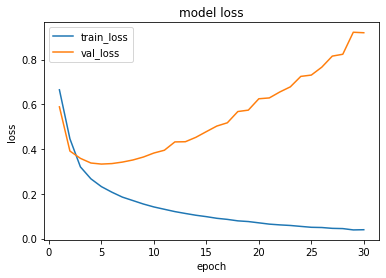

In [9]:
plot_acc(model=model,epochsnum=30)

In [10]:
#model has been overfitt b/c cost is non decreasing over validation data

#making model 2 and fitting for fewer epochs
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model2.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
model2.summary()
# train model
history= model2.fit(training_padded, 
                    y_train, 
                    validation_data=(testing_padded, y_test), 
                    epochs=10, 
                    verbose=2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
flatten (Flatten)            (None, 1920)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 24)                46104     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 25        
Total params: 206,129
Trainable params: 206,129
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
668/668 - 3s - loss: 0.4480 - accuracy: 0.7752 - val_loss: 0.3076 - val_accuracy: 0.8658
Epoch 2/10
668/668 - 2s - loss: 0.2033 - accuracy: 0.9218 - val_loss: 0.2909 - val_accuracy: 0.8750
Epoch 3/10
668/668 - 2s - loss: 0.1070 - accur

84/84 [==============================] - 0s 2ms/step - loss: 0.6823 - accuracy: 0.8557
Test accuracy: 0.8556720614433289


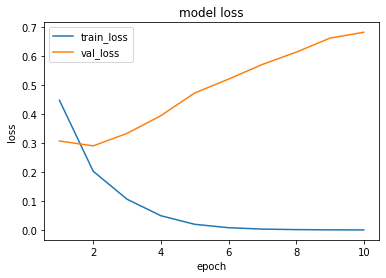

In [12]:
#showing accuracy of model2
plot_acc(model=model2,epochsnum=10)

In [13]:
#inputting a Long Short-Term Memory layer in our NN to increase accuracy on validation DS

#creating the buffed model
model_lstm = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_lstm.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
model_lstm.summary()



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                12544     
_________________________________________________________________
dense_4 (Dense)              (None, 24)                1560      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 25        
Total params: 174,129
Trainable params: 174,129
Non-trainable params: 0
_________________________________________________________________


In [14]:
#training our new model
history = model_lstm.fit(training_padded, 
                    y_train, 
                    validation_data=(testing_padded, y_test), 
                    epochs=10, 
                    verbose=2)

Epoch 1/10
668/668 - 43s - loss: 0.4022 - accuracy: 0.8034 - val_loss: 0.3475 - val_accuracy: 0.8405
Epoch 2/10
668/668 - 39s - loss: 0.2274 - accuracy: 0.9070 - val_loss: 0.3290 - val_accuracy: 0.8564
Epoch 3/10
668/668 - 39s - loss: 0.1580 - accuracy: 0.9391 - val_loss: 0.3782 - val_accuracy: 0.8560
Epoch 4/10
668/668 - 40s - loss: 0.1071 - accuracy: 0.9611 - val_loss: 0.4301 - val_accuracy: 0.8559
Epoch 5/10
668/668 - 40s - loss: 0.0681 - accuracy: 0.9765 - val_loss: 0.5053 - val_accuracy: 0.8458
Epoch 6/10
668/668 - 40s - loss: 0.0428 - accuracy: 0.9868 - val_loss: 0.5905 - val_accuracy: 0.8439
Epoch 7/10
668/668 - 40s - loss: 0.0277 - accuracy: 0.9917 - val_loss: 0.7259 - val_accuracy: 0.8416
Epoch 8/10
668/668 - 40s - loss: 0.0186 - accuracy: 0.9946 - val_loss: 0.8105 - val_accuracy: 0.8381
Epoch 9/10
668/668 - 40s - loss: 0.0159 - accuracy: 0.9947 - val_loss: 0.8590 - val_accuracy: 0.8390
Epoch 10/10
668/668 - 40s - loss: 0.0110 - accuracy: 0.9960 - val_loss: 1.0390 - val_accura

84/84 [==============================] - 2s 20ms/step - loss: 1.0390 - accuracy: 0.8386
Test accuracy: 0.8386372327804565


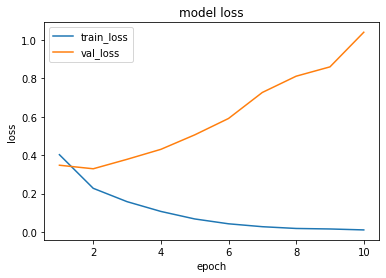

In [15]:
#plotting the accuracy of out buffed model
plot_acc(model=model_lstm,epochsnum=10)

### Conclusions

* It seems that model 2 has the overall best accuracy on the validation dataset (cost increases at the lowest rate).